# Метод Ньютона

[К оглавлению примеров](_contents.ipynb)

In [1]:
# Начальная настройка рабочей среды. Запустите эту ячейку перед началом работы!
from plotutils import * # Функции для рисования поверхностей и контурных графиков
%matplotlib inline
#%matplotlib
from matplotlib import rcParams
rcParams.update({'font.size': 16})  # Крупнее шрифт для графиков
#rcParams.update({'font.family': 'Arial'}) # Если нет русского языка на графиках
import sympy as sp # Пакет символьной математики
sp.init_printing() # Включить отображение выражений sympy в виде математических формул
import scipy.optimize as so
%precision 3
1;

# Тестовые функции

## Параболическая функция с минимумом

Функция: $f(x, y) = x^2 + y^2 $

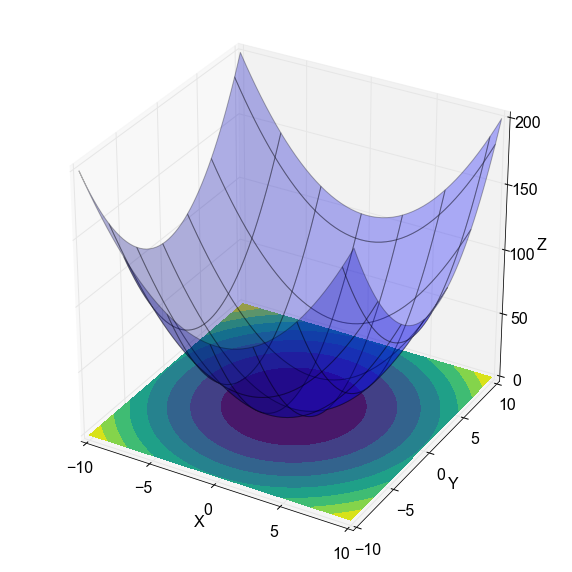

In [2]:
f = lambda x, y: x**2 + y**2
F = lambda X: f(X[0], X[1])
plotSurface(f)
plt.gcf().set_size_inches(10, 10)
#plt.savefig('parab2_surface.png', dpi=150)


Градиент:

$$\nabla f(x,y) = 
\left[
\begin{array}[c]\\
        2 x \\
        2 y \\
\end{array}
\right]
$$

Гессиан:

$$ \mathbf{H} = \left[\begin{matrix}2 & 0\\0 & 2\end{matrix}\right]$$

In [3]:
# Функция для вычисления градиента
grad_f = lambda x, y: np.array([2*x, 2*y])
grad_F = lambda X: grad_f(X[0], X[1])

# Функция для вычисления гессиана
hess_f = lambda x, y: np.array([[2, 0], 
                                [0, 2]])                                 
hess_F = lambda X : hess_f(X[0], X[1])

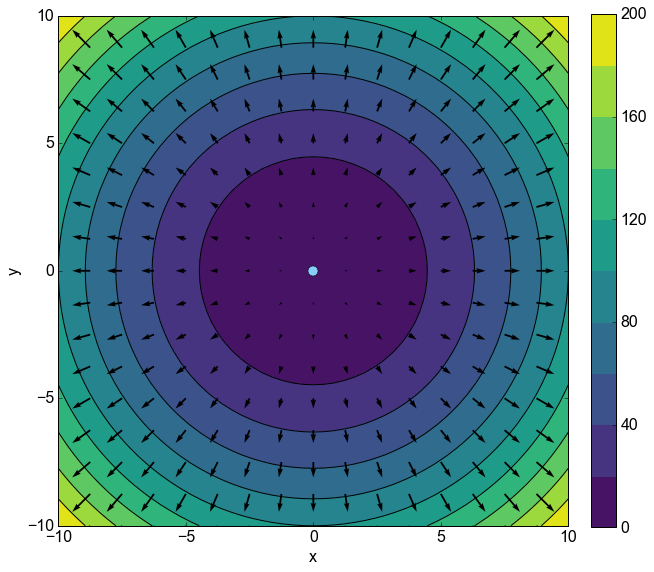

In [4]:
plotContours(f)
addGradients(grad_f, steps=17)
addPoint(0, 0)
#plt.savefig('parab2_gradients.png', dpi=150)

## Овражная функция

Функция: $k(x, y) = x^2 + 2 y^2 + x y$

Градиент:

$$\nabla f(x,y) = 
\left[
\begin{array}\\
        2 x + y \\
        x + 4y \\
\end{array}
\right]
$$

Гессиан:

$$\mathbf{H} = \left[\begin{matrix}2 & 1\\1 & 4\end{matrix}\right] $$

In [5]:
k = lambda x, y: x**2 + 2 * y**2 + x * y
K = lambda X: k(X[0], X[1])

In [6]:
# Функция для вычисления градиента:
grad_k = lambda x, y: np.array([2 * x + y, x + 4 * y])
grad_K = lambda X: grad_k(X[0], X[1])

# Функция для вычисления гессиана:
hess_k = lambda x, y: np.array([[2, 1], 
                                [1, 4]])                                 
hess_K = lambda X : hess_k(X[0], X[1])

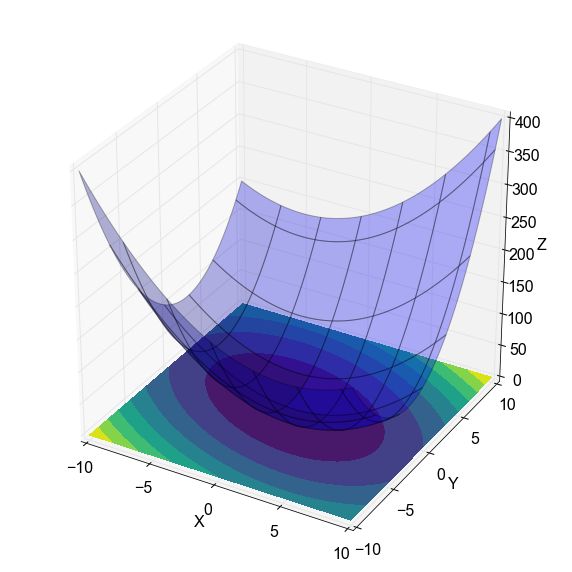

In [7]:
plotSurface(k)
plt.gcf().set_size_inches(10, 10)
#plt.savefig('interact_surface.png',dpi=150)

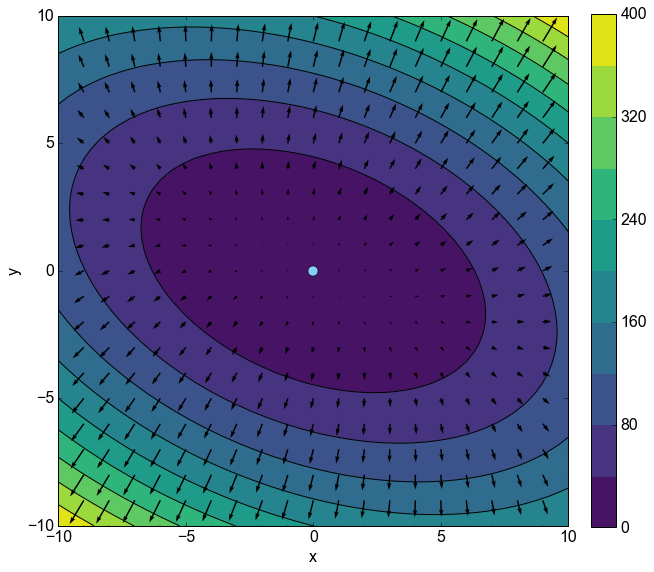

In [8]:
plotContours(k)
addGradients(grad_k)
addPoint(0, 0)
#plt.savefig('interact_gradients.png',dpi=150)

## Функция Розенброка

Функция Розенброка: $r(x, y) = 100(y - x^2)^2 + (1-x)^2 $
Стационарная точка (минимум) - $(1, 1)$

Градиент:

$$\nabla f(x, y) = \left[\begin{matrix}- 400 x \left(- x^{2} + y\right) + 2 x - 2\\- 200 x^{2} + 200 y\end{matrix}\right] $$

Гессиан:
$$\mathbf{H} = \left[\begin{matrix}1200 x^{2} - 400 y + 2 & - 400 x\\- 400 x & 200\end{matrix}\right] $$

In [9]:
r = lambda x, y: 100 * (y - x**2)**2 + (1 - x)**2
R = lambda X: r(X[0], X[1])

In [10]:
# Функция для вычисления градиента:
grad_r = lambda x, y: np.array([
        -400 * x * (y - x**2) + 2 * x - 2, 
        200 * y - 200 * x**2
    ])

grad_R = lambda X: grad_r(X[0], X[1])

In [11]:
# Функция для вычисления гессиана:
hess_r = lambda x, y: np.array([
        [1200 * x**2 - 400 * y + 2,  -400 * x],
        [-400*x, 200]
    ])

hess_R = lambda X : hess_r(X[0], X[1])

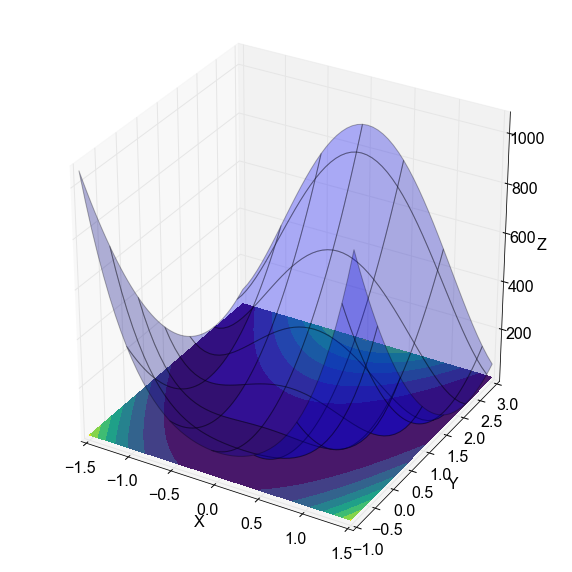

In [12]:
plotSurface(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
plt.gcf().set_size_inches(10, 10)

# Направление обзора и расстояние до наблюдателя
#plt.gca().view_init(elev=45, azim=-120)

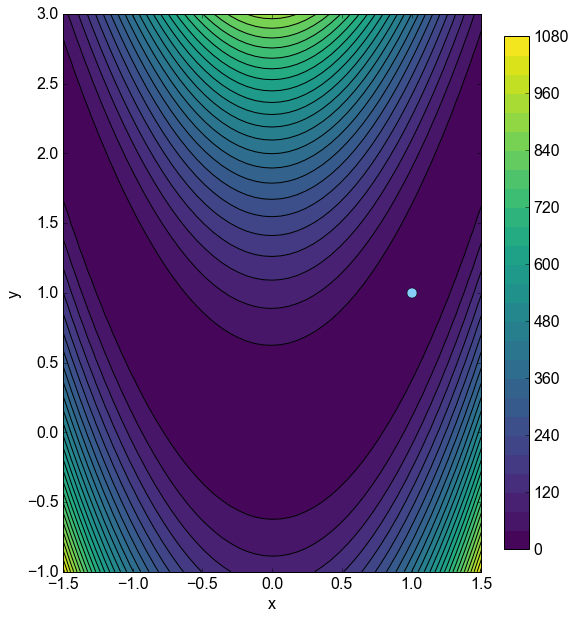

In [13]:
plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
addPoint(1, 1)
plt.gcf().set_size_inches(10, 10)

# Реализация метода Ньютона

In [14]:
# Метод Ньютона
def newton(f, X0, grad, hess, eps=0.01, trace=False, path=False, max_steps=1000):
    """
    Минимизация функции многих переменных методом Ньютона.    
    
    Аргументы:
    f - функция для минимизации (функия принимает векторный аргумент)
    X0 - начальная точка (вектор)
    grad - функция для вычисления градиента f в точке X
    hess - функция для вычисления гессиана f в точке X
    eps - точность локализации экстремума
    trace - нужно ли выводить шаги поиска
    path - нужно ли возаращать траекторию поиска        
    max_steps - максимальное число итераций (для предотвращения зацикливания)
    
    Возвращает кортеж: (x_min, f_min), если не требуется возвращать траекторию
    или кортеж: (x_min, f_min, path), где path - траектория (список словарей с результатами каждой итерации)
    """
    step = 0
    trajectory = []
    X0 = X0.astype('float64')
    
    Xk = X0 # точка старта    
    fk = f(Xk) # Вычисляем функцию в точке Xk
    
    if trace:
        
        print('%-3s %25s %25s %6s %6s %6s' % 
              ('Шаг', 'Xk   ', 'Sk   ', '|grad|', 'fk  ', 'delta_f'))    
    while step < max_steps:
        step += 1
        grad_k = grad(Xk) # Вычисляем градиент в точке Xk
        norm_k = np.linalg.norm(grad_k) # Вычисляем модуль градиента в точке Xk
        H_k = hess(Xk) # Вычисляем гессиан в точке Xk
        Sk = - np.linalg.inv(H_k).dot(grad_k) # Вычисляем направление и величину шага
        Xnext = Xk + Sk  # Вычисляем координату в следующей точке
        fnext = f(Xnext) # Вычисляем критерий в следующей точке
                
        if trace:
            print('%3d %25s %25s %6.3f %6.3f %+6.3f' % 
                  (step, Xk, Sk, norm_k, fk, fnext - fk))        
        if path:            
            results = { 'step' : step,
                       'Xk' : Xk,
                       'grad_k' : grad_k,
                       'Sk' : Sk,
                       'fk' : fk,
                       'Xnext' : Xnext,
                       'fnext' : fnext }
            trajectory.append(results)            
                
        if norm_k < eps : # выполнено условие остановки: модуль градиента близок к нулю
            #np.abs(fnext - fk) < eps : # выполнено условие остановки: критерий изменился слабо - выходим
            break

        fk = fnext
        Xk = Xnext
        
    if path:
        return Xk, fk, trajectory
    else:
        return Xk, fk
    

Шаг                     Xk                        Sk    |grad|   fk   delta_f
  1                 [ 2.  2.]                 [-2. -2.]  5.657  8.000 -8.000
  2                 [ 0.  0.]                 [-0. -0.]  0.000  0.000 +0.000


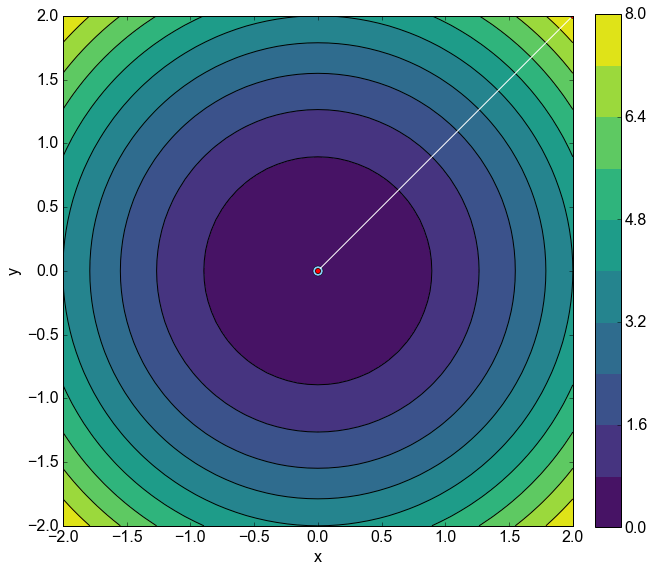

In [15]:
X_opt, f_opt, path = newton(F, np.array([2, 2]), grad_F, hess_F, trace=True, path=True, eps=0.01)
plotContours(f, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)

In [16]:
X_opt, f_opt, path = newton(K, np.array([2, 2]), grad_K, hess_K, trace=True, path=True, eps=0.01)

Шаг                     Xk                        Sk    |grad|   fk   delta_f
  1                 [ 2.  2.]                 [-2. -2.] 11.662 16.000 -16.000
  2 [  0.000e+00   4.441e-16] [ -0.000e+00  -4.441e-16]  0.000  0.000 -0.000


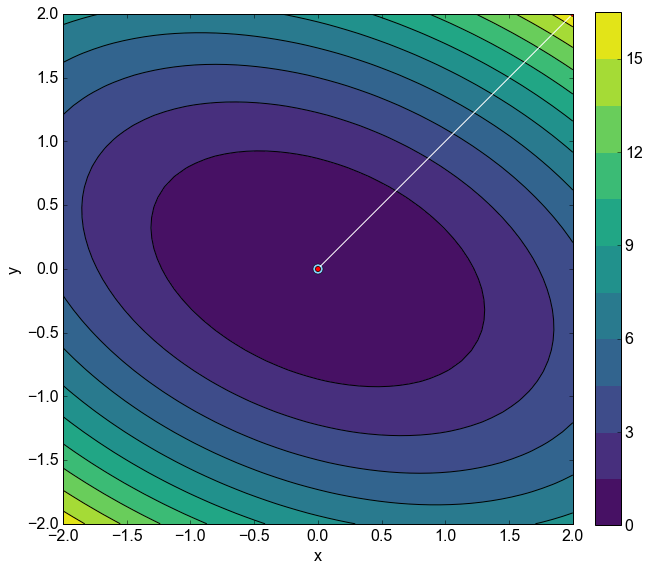

In [17]:
plotContours(k, xlim=(-2, 2), ylim=(-2, 2))
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 10)
addPoint(0, 0)
addPath(path, points=True, search_dir=False)
#plt.savefig('interact_newton.png', bbox_inches='tight')

In [18]:
X_opt, f_opt, path = newton(R, np.array([-1, 0]), grad_R, hess_R, trace=False, path=True, max_steps=1000)

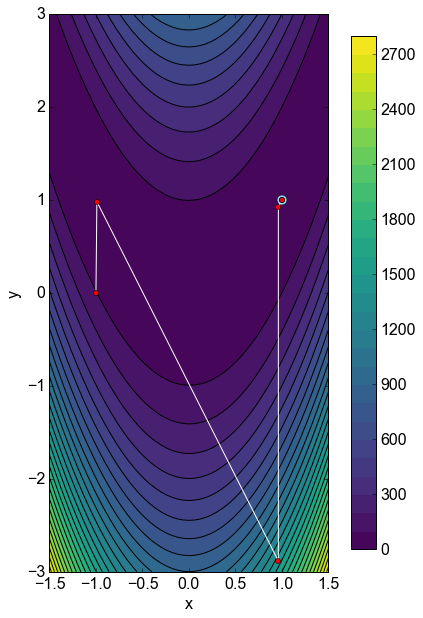

In [19]:
plotContours(r, xlim=(-1.5, 1.5), ylim=(-3.0, 3), levels=30)
#antigrad_f = lambda x, y: -1 * grad_f(x, y)
#addGradients(antigrad_f)
#plt.gcf().set_size_inches(10, 5)
addPoint(1, 1)
addPath(path, points=True, search_dir=False)
#plt.savefig('rosen_newton.png', bbox_inches='tight')

# Использование пакета `scipy.optimize`

Для минимизации многомерных функций в пакете `scipy.optimize` содержится функция `minimize()`. Чтобы ей воспользоваться, необходимо задать минимизируемую функцию (должна принимать векторный аргумент) и указать начальное приближение. Функция повзоляет выбрать применяемый метод, задав аргумент: `method=...`:   `'Nelder-Mead','Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'dogleg', 'trust-ncg'`

Некоторые методы требуют задать градиент (`jac=...`) и/или гессиан (`hess=`). В этом случае необходимо указать функции для их вычисления. Функция должна принимать векторный аргумент и возвращать одномерный массив (для градиента) или массив `n x n` (для гессиана).

## Сравнение траекторий поиска

In [20]:
# Функция для сохранения траектории поиска
def after_iter(X):
    result = {'Xk' : X, 'Xnext': X}
    path.append(result)

### Метод сопряженных градиентов

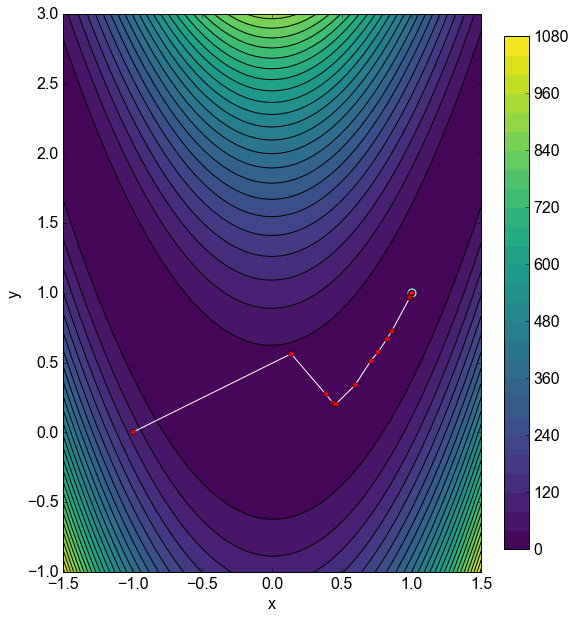

In [21]:
# Функция R(X) - вычисляет функцию Розенброка в точке X (задана в разделе 2.3)
# Функция grad_R(X) - вычисляет градиент функции Розенброка в точке X (задана в разделе 2.3)
# Функция hess_R(X) - вычисляет гессиан функции Розенброка в точке X (задана в разделе 2.3)

# Начальная точка:
X0 = np.array([-1, 0])

# Траектория поиска
path = [{'Xk' : X0}] # список результатов содержит только начальную точку

resCG = so.minimize(R, X0, jac=grad_R, method='CG', callback=after_iter)

plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True)

### Метод Ньютона и сопряженных градиентов

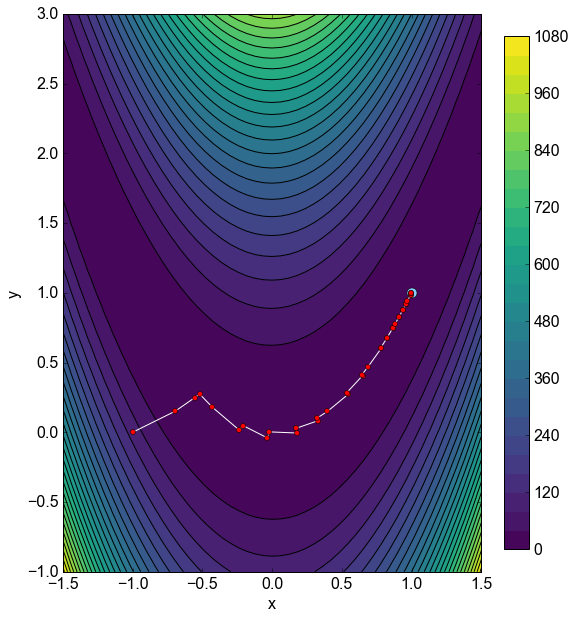

In [22]:
# Начальная точка:
X0 = np.array([-1, 0])

# Траектория поиска
path = [{'Xk' : X0}] # список результатов содержит только начальную точку
    
resNCG = so.minimize(R, X0, jac=grad_R, hess=hess_R, method='Newton-CG', callback=after_iter);

plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True)

### Квазиньютоновский метод - BFGS

Метод Бройдена-Флетчера-Гольдфарба-Шанно


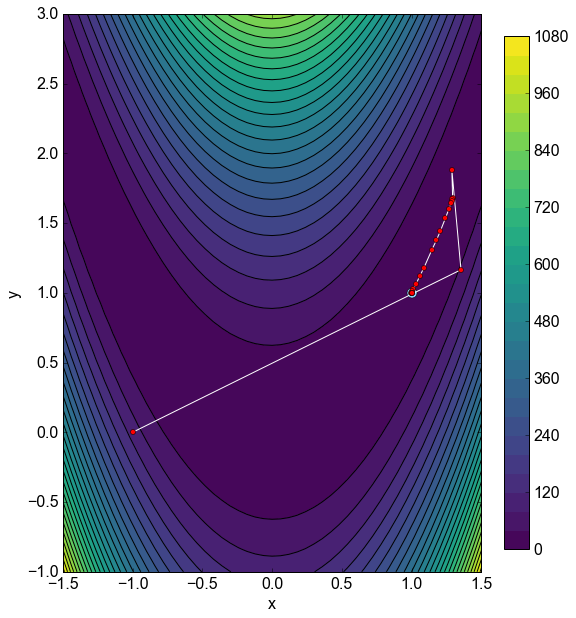

In [23]:
# Начальная точка:
X0 = np.array([-1, 0])

# Траектория поиска
path = [{'Xk' : X0}] # список результатов содержит только начальную точку

resBFGS = so.minimize(R, X0, jac=grad_R, method='BFGS', callback=after_iter)

plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True)

### Безградиентный метод Нелдера-Мида

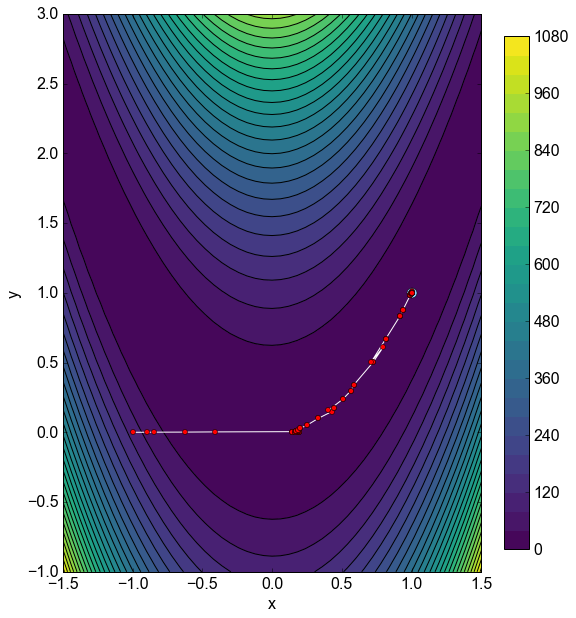

In [24]:
# Начальная точка:
X0 = np.array([-1, 0])

# Траектория поиска
path = [{'Xk' : X0}] # список результатов содержит только начальную точку

resNM = so.minimize(R, X0, method='Nelder-Mead', callback=after_iter)

plotContours(r, xlim=(-1.5, 1.5), ylim=(-1.0, 3), levels=30)
#plt.gcf().set_size_inches(10, 10)
addPoint(1, 1)
addPath(path, points=True)

## Сравнение количества итераций

In [25]:
resCG

     jac: array([ -2.088e-07,   1.042e-07])
    njev: 38
     fun: 2.7177778302601776e-17
       x: array([ 1.,  1.])
 success: True
    nfev: 38
 message: 'Optimization terminated successfully.'
  status: 0
     nit: 17

In [26]:
resNCG

     jac: array([ 0.012, -0.007])
    njev: 82
     fun: 7.79632319429697e-07
       x: array([ 0.999,  0.998])
 success: True
    nfev: 47
 message: 'Optimization terminated successfully.'
  status: 0
    nhev: 36
     nit: 36

In [27]:
resBFGS

      jac: array([  3.989e-06,  -1.989e-06])
     njev: 25
 hess_inv: array([[ 0.5  ,  1.   ],
       [ 1.   ,  2.005]])
      fun: 9.921228707074729e-15
        x: array([ 1.,  1.])
  success: True
     nfev: 25
  message: 'Optimization terminated successfully.'
   status: 0
      nit: 20

In [28]:
resNM

  status: 0
     nit: 83
     fun: 9.8363137957803262e-10
       x: array([ 1.,  1.])
 success: True
    nfev: 153
 message: 'Optimization terminated successfully.'

## Сравнение времени поиска

In [29]:
%%timeit
so.minimize(R, X0, jac=grad_R, method='CG');

100 loops, best of 3: 2.16 ms per loop


In [30]:
%%timeit
so.minimize(R, X0, jac=grad_R, hess=hess_R, method='Newton-CG');

100 loops, best of 3: 7.32 ms per loop


In [31]:
%%timeit
so.minimize(R, X0, jac=grad_R, method='BFGS');

100 loops, best of 3: 2.54 ms per loop


In [32]:
%%timeit
so.minimize(R, X0, method='Nelder-Mead');

100 loops, best of 3: 5.42 ms per loop
